## 구드 연결 & 압축해제

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#local에 풀기
#data_location 위치에 다운로드받은 zip파일이 위치한 디렉토리 입력

#!mkdir /content/datasets # 폴더 없을 경우 생성
!unzip "/content/drive/MyDrive/Colab Notebooks/book_recommend/open.zip" -d "//content/drive/MyDrive/Colab Notebooks/book_recommend"
#!unzip "/content/drive/MyDrive/uniddata/test.zip" -d "/content/datasets/test"
%cd /content/

Archive:  /content/drive/MyDrive/Colab Notebooks/book_recommend/open.zip
replace //content/drive/MyDrive/Colab Notebooks/book_recommend/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content


1. 리더 보드

평가 산식 : RMSE (Root Mean Squared Error)


Public score : 전체 테스트 데이터 중 30%
Private score : 전체 테스트 데이터 중 나머지 70%
동점자 발생의 경우, 기존 리더보드 순위 산정 방식을 따름 [링크]의 '리더보드 점수' 부분을 참고

# BaseLine

In [ ]:
# Suprise 패키지 설치
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163494 sha256=b89d39ba813bf74c0dfb6c9bae0ee62c0ba62df8492daff0627f6e7527b49e66
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# Surprise 라이브러리 : 추천시스템 구현을 도와주는 라이브러리

- 프로세스 : 데이터로딩 - 모델설정 및 학습 - 예측 및 평가
  - 무비렌즈라는 오픈 데이터셋에 기초해서 만들어짐
  - 그래서 포맷을 '사용자 - 아이템 - 평점' 으로 순서를 맞춰 주어야 함
- 주요 메소드
  - 데이터 로딩
    - 내장 데이터 로딩 </br>
    data = Dataset.load_builtin('m1-100k') </br>
    train,tesst = train_test_split(data, test_size = 0.25, random_state=42)
    - csv 파일 로딩</br>
    ratings = pd.read_csv("ratings.csv") </br>
    #포맷 변경해서 따로 저장. 이때 인덱스와 헤더(컬럼명) 없애줘야함)</br>
    ratings.to_csv('rating_surprise.csv', index= False, header=False) </br>
    reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5,5))</br>
    data = Dataset.load_from_file('rating_surprise.csv',reader=reader)
    - 판다스의 데이터 프레임 로딩</br>
    data = Dataset.load_from(ratings[['userId','movied',;rating']], reader=reader)

# Data Load

In [14]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/book_recommend/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/book_recommend/test.csv')

In [ ]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


location 분석

In [15]:
df_location = train[['User-ID','Book-ID','Location','Book-Rating']]
df_location_test = train[['User-ID','Book-ID','Location','Book-Rating']]

In [16]:
df_location["country"] = df_location['Location'].apply(lambda x: x.split(',')[-1].strip())
df_location["state"] = df_location['Location'].apply(lambda x: x.split(',')[-2].strip())
df_location["city"] = df_location['Location'].apply(lambda x: x.split(',')[-3].strip())

<ipython-input-16-027052d3793c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["country"] = df_location['Location'].apply(lambda x: x.split(',')[-1].strip())
<ipython-input-16-027052d3793c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["state"] = df_location['Location'].apply(lambda x: x.split(',')[-2].strip())
<ipython-input-16-027052d3793c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [17]:
df_location = df_location.drop(columns=["Location"])

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

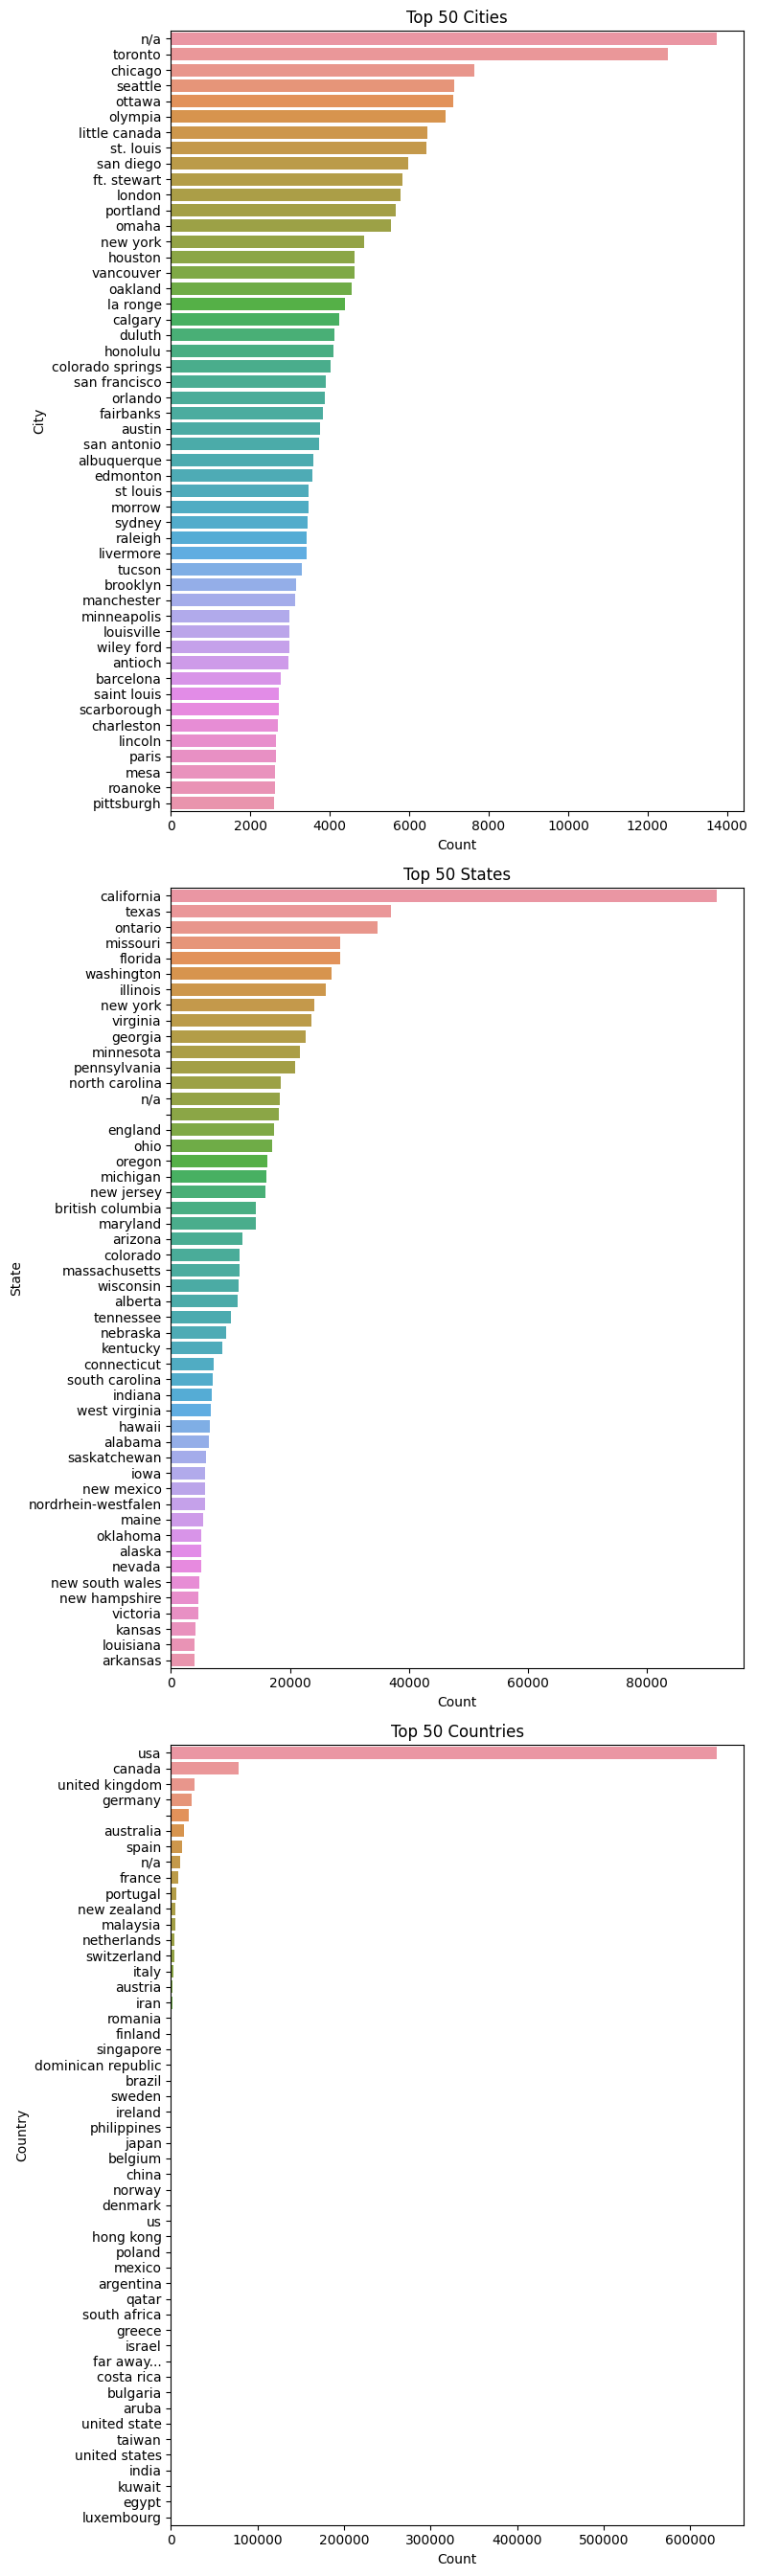

In [19]:
# Plotting the top 50 cities
ds_city = df_location['city'].value_counts().reset_index()
ds_city.columns = ['city', 'count']
ds_city = ds_city.sort_values('count', ascending=False).head(50)

# Plotting the top 50 states
ds_state = df_location['state'].value_counts().reset_index()
ds_state.columns = ['state', 'count']
ds_state = ds_state.sort_values('count', ascending=False).head(50)

# Plotting the top 50 countries
ds_country = df_location['country'].value_counts().reset_index()
ds_country.columns = ['country', 'count']
ds_country = ds_country.sort_values('count', ascending=False).head(50)

# Creating subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 27))

# Plotting cities
sns.barplot(data=ds_city, x='count', y='city', ax=axes[0])
axes[0].set_title('Top 50 Cities')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('City')

# Plotting states
sns.barplot(data=ds_state, x='count', y='state', ax=axes[1])
axes[1].set_title('Top 50 States')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('State')

# Plotting countries
sns.barplot(data=ds_country, x='count', y='country', ax=axes[2])
axes[2].set_title('Top 50 Countries')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Country')

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder

<ipython-input-21-d68d3a8514a3>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_location_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


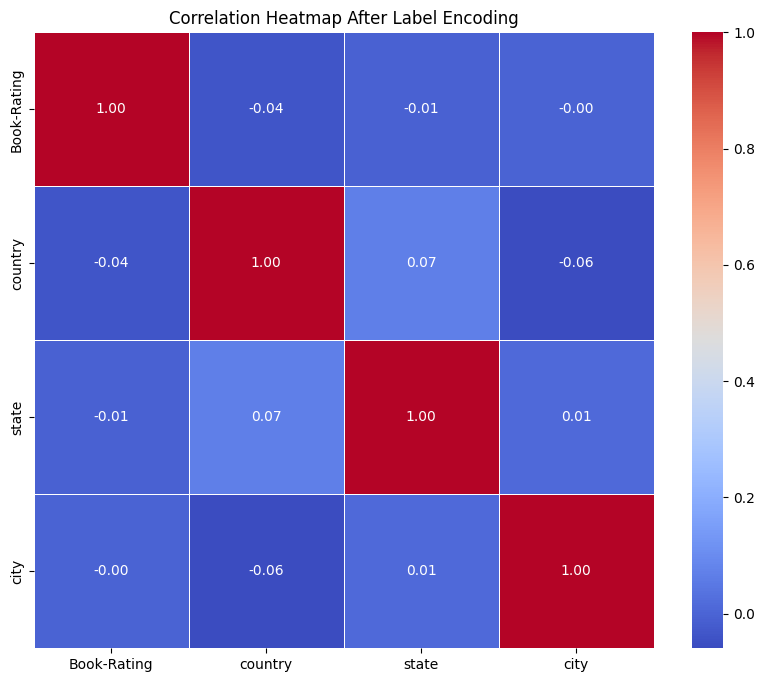

In [21]:
label_encoder = LabelEncoder()
df_location_encoded = df_location.copy()
df_location_encoded['city'] = label_encoder.fit_transform(df_location['city'])
df_location_encoded['state'] = label_encoder.fit_transform(df_location['state'])
df_location_encoded['country'] = label_encoder.fit_transform(df_location['country'])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_location_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap After Label Encoding')
plt.show()

In [86]:
replacement_dict = {'n/a': 'unknown'}
df_location['city'] = df_location['city'].replace(replacement_dict)

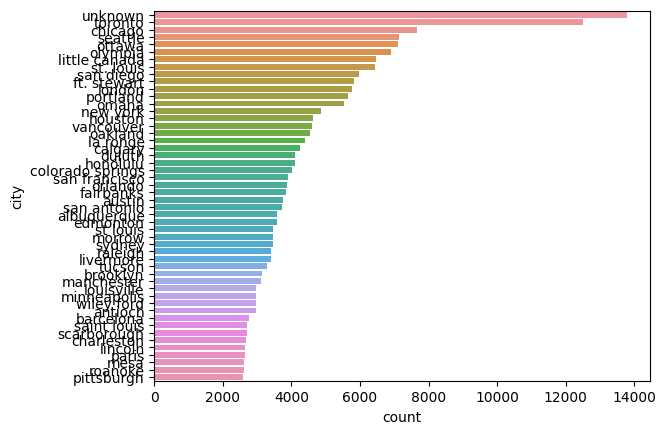

In [87]:
# Plotting the top 50 cities
ds_city = df_location['city'].value_counts().reset_index()
ds_city.columns = ['city', 'count']
ds_city = ds_city.sort_values('count', ascending=False).head(50)

sns.barplot(data=ds_city, x='count', y='city')
plt.show()

In [22]:
#city의 결측치를 제거하고 수행하자
df_loc_na = df_location[df_location["city"] != "n/a"]

In [11]:
df_loc_na

,User-ID,Book-ID,Book-Rating,country,state,city
0,USER_00000,BOOK_044368,8,canada,new brunswick,sackville
1,USER_00000,BOOK_081205,8,canada,new brunswick,sackville
2,USER_00000,BOOK_086781,0,canada,new brunswick,sackville
3,USER_00000,BOOK_098622,0,canada,new brunswick,sackville
4,USER_00000,BOOK_180810,8,canada,new brunswick,sackville
...,...,...,...,...,...,...
871388,USER_92096,BOOK_081138,0,usa,minnesota,minneapolis
871389,USER_92097,BOOK_258124,0,usa,texas,temple
871390,USER_92098,BOOK_071848,0,canada,ontario,ottawa
871391,USER_92099,BOOK_252599,8,usa,minnesota,maple grove


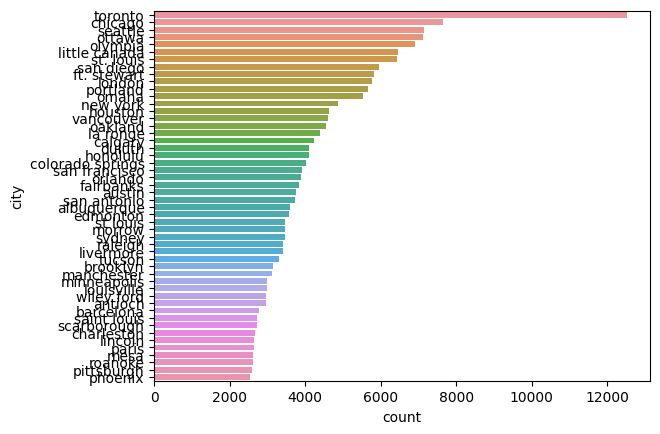

In [23]:
# Plotting the top 50 cities
ds_city = df_loc_na['city'].value_counts().reset_index()
ds_city.columns = ['city', 'count']
ds_city = ds_city.sort_values('count', ascending=False).head(50)

sns.barplot(data=ds_city, x='count', y='city')
plt.show()

<ipython-input-24-7061054ed265>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_location_na_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


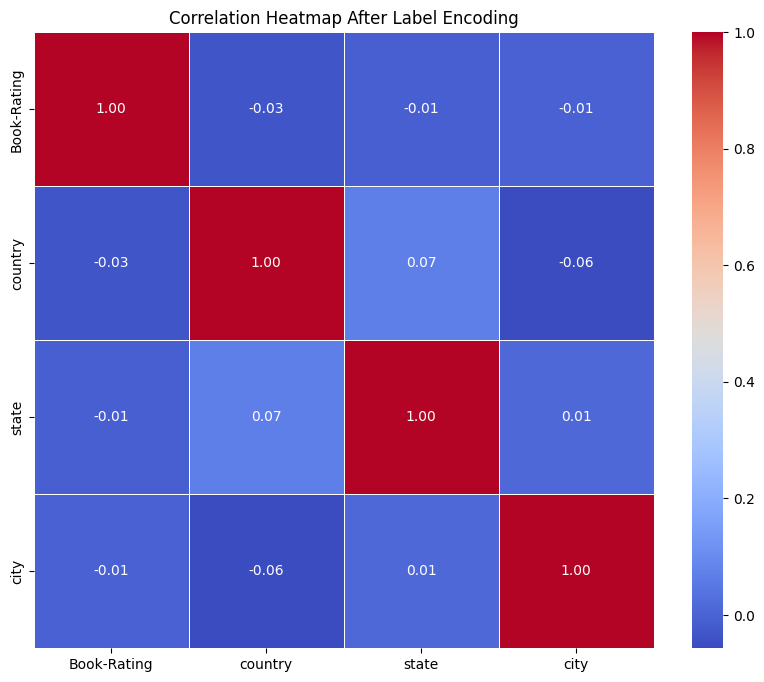

In [24]:
label_encoder = LabelEncoder()
df_location_na_encoded = df_loc_na.copy()
df_location_na_encoded['city'] = label_encoder.fit_transform(df_loc_na['city'])
df_location_na_encoded['state'] = label_encoder.fit_transform(df_loc_na['state'])
df_location_na_encoded['country'] = label_encoder.fit_transform(df_loc_na['country'])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_location_na_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap After Label Encoding')
plt.show()

# EDA

<Axes: title={'center': 'Book-Rating distribution(Train)'}, ylabel='Frequency'>

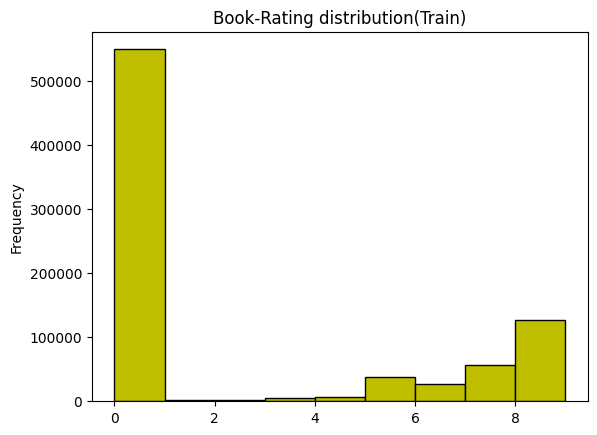

In [ ]:
train['Book-Rating'].plot.hist(bins=range(0,10,1),color='y', edgecolor='k', title = 'Book-Rating distribution(Train)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Book-Rating distribution(Train)'}, ylabel='Frequency'>

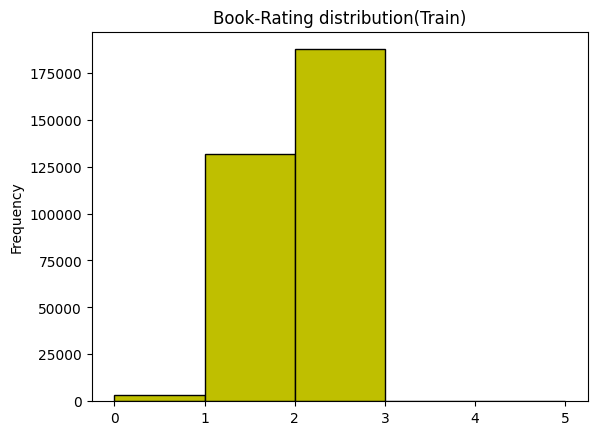

In [ ]:
# 로그 처리시
import numpy as np
np.log(train['Book-Rating']).plot.hist(bins=range(0,6,1),color='y', edgecolor='k', title = 'Book-Rating distribution(Train)')

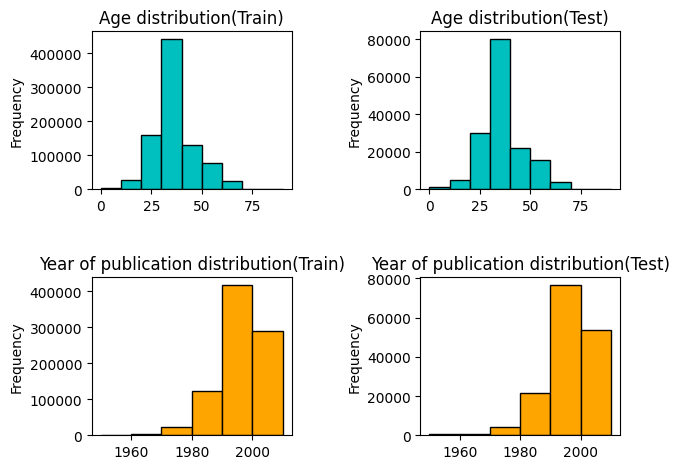

In [ ]:
#train,test 데이터의 각각 나이별 분포
import matplotlib.pyplot as plt
plt.subplot(2, 2, 1)
train['Age'].plot.hist(bins=range(0,100,10),color='c', edgecolor='k', title = 'Age distribution(Train)')
plt.subplot(2, 2, 2)
test['Age'].plot.hist(bins=range(0,100,10),color='c', edgecolor='k', title = 'Age distribution(Test)')
plt.subplot(2, 2, 3)
train['Year-Of-Publication'].plot.hist(bins=range(1950,2020,10), color='orange', edgecolor='k', title = 'Year of publication distribution(Train)')
plt.subplot(2, 2, 4)
test['Year-Of-Publication'].plot.hist(bins=range(1950,2020,10),color='orange', edgecolor='k', title = 'Year of publication distribution(Test)')

plt.tight_layout(
    h_pad=3, # 세로 간격 조절
    w_pad=4) # 가로 간격 조걸

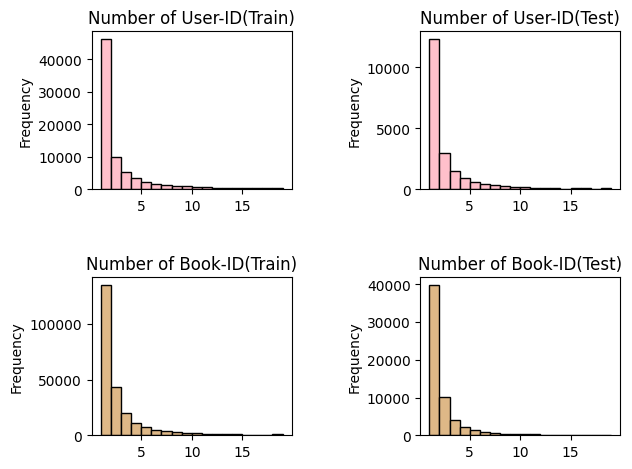

In [ ]:
plt.subplot(2, 2, 1)
et0= train.groupby('User-ID').count()
et0['ID'].plot.hist(bins=range(1,20,1),color='pink', edgecolor='k',title = 'Number of User-ID(Train)')
plt.subplot(2, 2, 2)
et1= test.groupby('User-ID').count()
et1['ID'].plot.hist(bins=range(1,20,1),color='pink', edgecolor='k',title = 'Number of User-ID(Test)')
plt.subplot(2, 2, 3)
et0= train.groupby('Book-ID').count()
et0['ID'].plot.hist(bins=range(1,20,1),color='burlywood', edgecolor='k',title = 'Number of Book-ID(Train)')
plt.subplot(2, 2, 4)
et1= test.groupby('Book-ID').count()
et1['ID'].plot.hist(bins=range(1,20,1),color='burlywood', edgecolor='k',title = 'Number of Book-ID(Test)')

plt.tight_layout(
    h_pad=3, # 세로 간격 조절
    w_pad=4) # 가로 간격 조걸

In [ ]:
import seaborn as sns
# 작가별 count
# 저자를 기준으로 숫자를 센다. 인덱스는 저자명이 된다
et = test.groupby('Book-Author').count()

In [ ]:
et.head()

,ID,User-ID,Book-ID,Age,Location,Book-Title,Year-Of-Publication,Publisher
Book-Author,,,,,,,,
J. D. Landis,1,1,1,1,1,1,1,1
Mimma Balia,1,1,1,1,1,1,1,1
"""""Ron""",1,1,1,1,1,1,1,1
'N Sync,1,1,1,1,1,1,1,1
142 moms from all over the world,1,1,1,1,1,1,1,1


In [ ]:
et['name']= et.index #et데이터의 name컬럼의 리스트
et = et[['name','ID']]
et = et.drop_duplicates(['name'])
# Top 10 추출
et_top10 = et.sort_values(by="ID", ascending=False).head(10)

In [ ]:
et.head()

,name,ID
Book-Author,,
J. D. Landis,J. D. Landis,1
Mimma Balia,Mimma Balia,1
"""""Ron""","""""Ron""",1
'N Sync,'N Sync,1
142 moms from all over the world,142 moms from all over the world,1


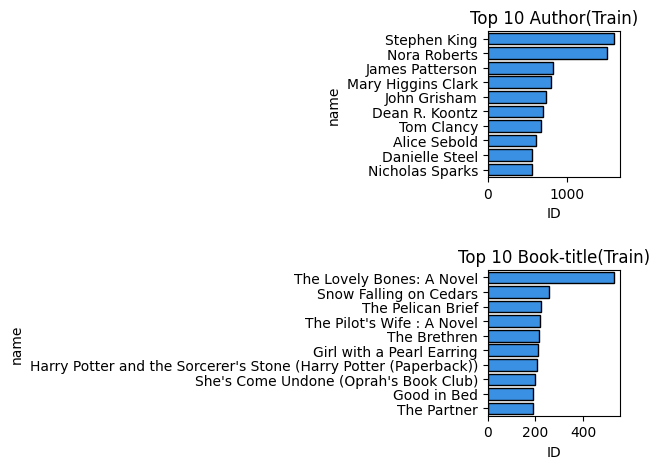

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
sns.barplot(data=et_top10, y="name", x="ID", orient='h', edgecolor='k',color='dodgerblue')
plt.title('Top 10 Author(Train)')


# Book-Title별 count
et = test.groupby('Book-Title').count()
et['name']= et.index
et = et[['name','ID']]
et = et.drop_duplicates(['name'])
# Top 10 추출
et_top10 = et.sort_values(by="ID", ascending=False).head(10)

plt.subplot(2, 1, 2)
sns.barplot(data=et_top10, y="name", x="ID", orient='h', edgecolor='k',color='dodgerblue')
plt.title('Top 10 Book-title(Train)')

plt.tight_layout(
    h_pad=2, # 세로 간격 조절
    w_pad=0) # 가로 간격 조절

# 분석 2차

In [ ]:
import numpy as np
# 각 변수별 평균 평점 추출

train['ID_avg'] = df_location_na_encoded.groupby(['User-ID']).transform(np.mean)['Book-Rating']
train['book_avg'] = df_location_na_encoded.groupby(['Book-ID']).transform(np.mean)['Book-Rating']

train['country_avg'] = df_location_na_encoded.groupby(['country']).transform(np.mean)['Book-Rating']
train['state_avg'] = df_location_na_encoded.groupby(['state']).transform(np.mean)['Book-Rating']
train['city_avg'] = df_location_na_encoded.groupby(['city']).transform(np.mean)['Book-Rating']

In [26]:
# 각 변수별 평균 평점 추출
train['ID_avg'] = df_location_na_encoded.groupby(['User-ID']).transform(np.mean)['Book-Rating']
train['book_avg'] = df_location_na_encoded.groupby(['Book-ID']).transform(np.mean)['Book-Rating']

train['country_avg'] = df_location_na_encoded.groupby(['country']).transform(np.mean)['Book-Rating']
train['state_avg'] = df_location_na_encoded.groupby(['state']).transform(np.mean)['Book-Rating']
train['city_avg'] = df_location_na_encoded.groupby(['city']).transform(np.mean)['Book-Rating']

<ipython-input-26-1315f6c4f5e0>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train['ID_avg'] = df_location_na_encoded.groupby(['User-ID']).transform(np.mean)['Book-Rating']
<ipython-input-26-1315f6c4f5e0>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train['book_avg'] = df_location_na_encoded.groupby(['Book-ID']).transform(np.mean)['Book-Rating']
<ipython-input-26-1315f6c4f5e0>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for 

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871393 entries, 0 to 871392
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   871393 non-null  object 
 1   User-ID              871393 non-null  object 
 2   Book-ID              871393 non-null  object 
 3   Book-Rating          871393 non-null  int64  
 4   Age                  871393 non-null  float64
 5   Location             871393 non-null  object 
 6   Book-Title           871393 non-null  object 
 7   Book-Author          871393 non-null  object 
 8   Year-Of-Publication  871393 non-null  float64
 9   Publisher            871393 non-null  object 
 10  ID_avg               857661 non-null  float64
 11  book_avg             857661 non-null  float64
 12  country_avg          857661 non-null  float64
 13  state_avg            857661 non-null  float64
 14  city_avg             857661 non-null  float64
dtypes: float64(7), in

In [47]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857661 entries, 0 to 871392
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   857661 non-null  object 
 1   User-ID              857661 non-null  object 
 2   Book-ID              857661 non-null  object 
 3   Book-Rating          857661 non-null  int64  
 4   Age                  857661 non-null  float64
 5   Location             857661 non-null  object 
 6   Book-Title           857661 non-null  object 
 7   Book-Author          857661 non-null  object 
 8   Year-Of-Publication  857661 non-null  float64
 9   Publisher            857661 non-null  object 
 10  ID_avg               857661 non-null  float64
 11  book_avg             857661 non-null  float64
 12  country_avg          857661 non-null  float64
 13  state_avg            857661 non-null  float64
 14  city_avg             857661 non-null  float64
dtypes: float64(7), in

In [27]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,ID_avg,book_avg,country_avg,state_avg,city_avg
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira,4.75,2.428571,2.84704,3.12688,4.557377
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,4.75,4.000000,2.84704,3.12688,4.557377
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,4.75,0.000000,2.84704,3.12688,4.557377
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon,4.75,3.000000,2.84704,3.12688,4.557377
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,4.75,1.538462,2.84704,3.12688,4.557377


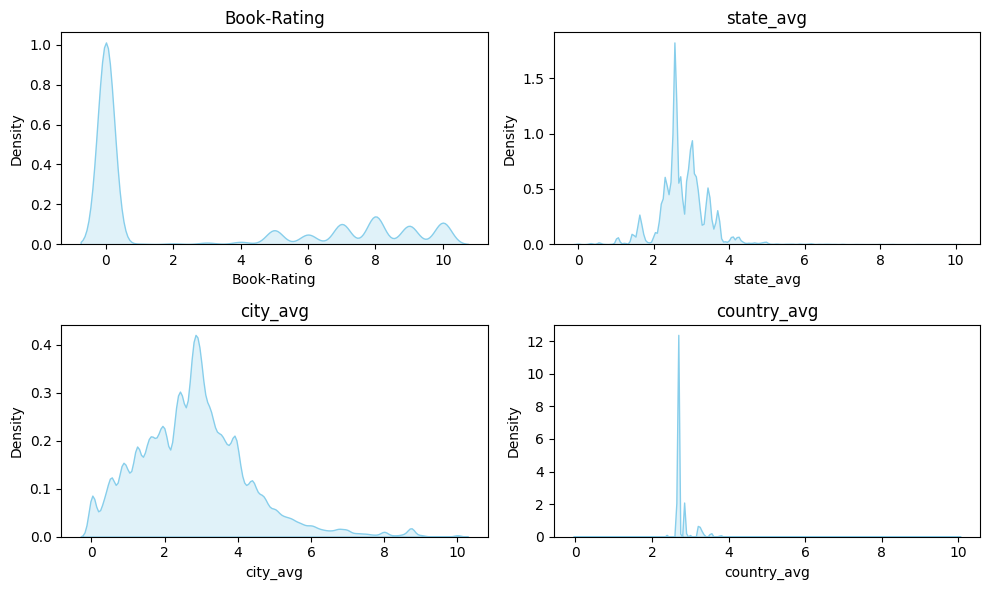

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Plotting cities
sns.kdeplot(train["Book-Rating"], fill=True, color='skyblue', ax=axes[0][0])
axes[0][0].set_title('Book-Rating')
axes[0][0].set_xlabel('Book-Rating')
axes[0][0].set_ylabel('Density')

# Plotting states
sns.kdeplot(train["city_avg"], fill=True, color='skyblue',ax=axes[1][0])
axes[1][0].set_title('city_avg')
axes[1][0].set_xlabel('city_avg')
axes[1][0].set_ylabel('Density')

# Plotting countries
sns.kdeplot(train["state_avg"], fill=True, color='skyblue',ax=axes[0][1])
axes[0][1].set_title('state_avg')
axes[0][1].set_xlabel('state_avg')
axes[0][1].set_ylabel('Density')

sns.kdeplot(train["country_avg"], fill=True, color='skyblue',ax=axes[1][1])
axes[1][1].set_title('country_avg')
axes[1][1].set_xlabel('country_avg')
axes[1][1].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
X1 = train[['country_avg']]

y1 = train[['Book-Rating']]

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

def foldTest(train_x, train_y):
  etr_pred = np.zeros(train_y.shape[0])
  etr_val = []

  for n, (tr_idx, val_idx) in enumerate(kf.split(train_x, train_y)) :
      tr_x, tr_y = train_x.iloc[tr_idx],train_y.iloc[tr_idx]
      val_x, val_y = train_x.iloc[val_idx], train_y.iloc[val_idx]

      etr = LinearRegression()
      etr.fit(tr_x, tr_y)

      val_pred = etr.predict(val_x)
      val_nmae = np.sqrt(mean_squared_error(val_y, val_pred.reshape(-1,1)))
      etr_val.append(val_nmae)
      print(f'{n + 1} FOLD NMAE = {val_nmae}')

  print(f'5FOLD Mean of NMAE = {np.mean(etr_val)}')


In [54]:
print("country")
X1 = train[['country_avg']]
y1 = train[['Book-Rating']]
foldTest(X1,y1)

country_avg

1 FOLD NMAE = 3.826576044336695
2 FOLD NMAE = 3.8281440634998876
3 FOLD NMAE = 3.8203148199087047
4 FOLD NMAE = 3.8211593933345083
5 FOLD NMAE = 3.8290649246277817
5FOLD Mean of NMAE = 3.8250518491415155


In [56]:
print("country&state")
X1 = train[['country_avg','state_avg']]
y1 = train[['Book-Rating']]
foldTest(X1,y1)

country&state
1 FOLD NMAE = 3.7805712336266537
2 FOLD NMAE = 3.7819321881375716
3 FOLD NMAE = 3.77444013464192
4 FOLD NMAE = 3.773254457422626
5 FOLD NMAE = 3.7837521285435174
5FOLD Mean of NMAE = 3.7787900284744573


In [57]:
print("country&state&city")
X1 = train[['country_avg','state_avg','city_avg']]
y1 = train[['Book-Rating']]
foldTest(X1,y1)

country&state&city
1 FOLD NMAE = 3.531632141851363
2 FOLD NMAE = 3.5278917148070605
3 FOLD NMAE = 3.5265147030240964
4 FOLD NMAE = 3.527498029162076
5 FOLD NMAE = 3.5394180075184614
5FOLD Mean of NMAE = 3.530590919272611


In [59]:
print("BookID & UserID")
X1 = train[['ID_avg','book_avg']]
y1 = train[['Book-Rating']]
foldTest(X1,y1)

BookID & UserID
1 FOLD NMAE = 2.734208039999458
2 FOLD NMAE = 2.733844267170948
3 FOLD NMAE = 2.739182765860263
4 FOLD NMAE = 2.727227779974813
5 FOLD NMAE = 2.7449707042184572
5FOLD Mean of NMAE = 2.7358867114447882


In [60]:
print("BookID & UserID&country")
X1 = train[['ID_avg','book_avg','country_avg']]
y1 = train[['Book-Rating']]
foldTest(X1,y1)

BookID & UserID&country
1 FOLD NMAE = 2.733711937778495
2 FOLD NMAE = 2.7328552953320577
3 FOLD NMAE = 2.7387442436804417
4 FOLD NMAE = 2.7264819951614268
5 FOLD NMAE = 2.744286262649575
5FOLD Mean of NMAE = 2.735215946920399


In [61]:
print("BookID & UserID&country&state")
X1 = train[['ID_avg','book_avg','country_avg','state_avg']]
y1 = train[['Book-Rating']]
foldTest(X1,y1)

BookID & UserID&country&state
1 FOLD NMAE = 2.732924562753896
2 FOLD NMAE = 2.732040037931976
3 FOLD NMAE = 2.7379774977533837
4 FOLD NMAE = 2.7258341352575584
5 FOLD NMAE = 2.7434585152854853
5FOLD Mean of NMAE = 2.73444694979646


In [74]:
df_location_test = test[['User-ID','Book-ID','Location']]

df_location_test ["country"] = df_location_test['Location'].apply(lambda x: x.split(',')[-1].strip())
df_location_test ["state"] = df_location_test['Location'].apply(lambda x: x.split(',')[-2].strip())
df_location_test ["city"] = df_location_test['Location'].apply(lambda x: x.split(',')[-3].strip())


<ipython-input-74-8ebbddc8ff83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location_test ["country"] = df_location_test['Location'].apply(lambda x: x.split(',')[-1].strip())
<ipython-input-74-8ebbddc8ff83>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location_test ["state"] = df_location_test['Location'].apply(lambda x: x.split(',')[-2].strip())
<ipython-input-74-8ebbddc8ff83>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [76]:
country_train = df_location['country'].unique()
country_test = df_location_test["country"].unique()

In [77]:
set(country_test)-set(country_train)

{'angola',
 'c.a.',
 'kosovo',
 'la suisse',
 'lkjlj',
 'maracopa',
 'orange co',
 'ouranos',
 'republic of panama',
 'samoa',
 'san franicsco',
 'senegal',
 'tonga',
 'u.s.a>',
 'ua',
 'united states of america',
 'usa & canada'}

# 분석 (데이콘)

In [ ]:
# 나이 구분 컬럼 추가
def func(x) :
    if x < 10:
        return "00대"
    elif x < 20 :
        return "10대"
    elif x < 30 :
        return "20대"
    elif x < 40 :
        return "30대"
    elif x < 50 :
        return "40대"
    elif x < 60 :
        return "50대"
    elif x < 70 :
        return "60대"
    elif x < 80 :
        return "70대"
    elif x < 90 :
        return "80대"
    elif x < 100 :
        return "90대"
    elif x >= 100 :
        return "100대"

train["age_gubn"] = train["Age"].apply(lambda x : func(x))
test["age_gubn"] = test["Age"].apply(lambda x : func(x))

In [ ]:
# location 컬럼에서 첫번째 변수만 분리 사용 (train & test)
data_list = train['Location'].str.split(',')

train['town'] = data_list.str.get(0)

data_list = test['Location'].str.split(',')

test['town'] = data_list.str.get(0)

In [ ]:
# 출판년도컬럼 추가
def func2(x) :
    if x == -1:
        return "unknown"
    elif x < 1960 :
        return "1950s"
    elif x < 1970 :
        return "1960s"
    elif x < 1980 :
        return "1970s"
    elif x < 1990 :
        return "1980s"
    elif x < 2000 :
        return "1990s"
    elif x >= 2000 :
        return "2000s"

train["Publication_Year_gubn"] = train["Year-Of-Publication"].apply(lambda x : func2(x))
test["Publication_Year_gubn"] = test["Year-Of-Publication"].apply(lambda x : func2(x))

In [ ]:
import numpy as np
# 각 변수별 평균 평점 추출
train['ID_avg'] = train.groupby(['User-ID']).transform(np.mean)['Book-Rating']
train['book_avg'] = train.groupby(['Book-ID']).transform(np.mean)['Book-Rating']

train['book_author_avg'] = train.groupby(['Book-Author']).transform(np.mean)['Book-Rating']
train['book_publisher_avg'] = train.groupby(['Publisher']).transform(np.mean)['Book-Rating']
train['pyg_avg'] = train.groupby(['Publication_Year_gubn']).transform(np.mean)['Book-Rating']
train['age_gubn_avg'] = train.groupby(['age_gubn']).transform(np.mean)['Book-Rating']
train['town_avg'] = train.groupby(['town']).transform(np.mean)['Book-Rating']

train['book_author_q5'] = train.groupby(['Book-Author'])['Book-Rating'].transform(lambda x: x.quantile(q=0.5))
train['book_publisher_q5'] = train.groupby(['Publisher'])['Book-Rating'].transform(lambda x: x.quantile(q=0.5))
train['pyg_q5'] = train.groupby(['Publication_Year_gubn'])['Book-Rating'].transform(lambda x: x.quantile(q=0.5))
train['age_gubn_q5'] = train.groupby(['age_gubn'])['Book-Rating'].transform(lambda x: x.quantile(q=0.5))
train['town_q5'] = train.groupby(['town'])['Book-Rating'].transform(lambda x: x.quantile(q=0.5))

In [ ]:
train.head()

In [ ]:
# Book-rating 데이터
X1 = train[['ID_avg','book_avg']]

y1 = train[['Book-Rating']]

# User-ID 데이터
x11 = train[['age_gubn_avg','town_avg',
             'age_gubn_q5','town_q5']]

y11 = train[['ID_avg']]

# Book-ID 데이터
x12 = train[['book_author_avg','book_publisher_avg','pyg_avg',
           'book_author_q5','book_publisher_q5','pyg_q5']]

y12 = train[['book_avg']]

In [ ]:
X1.head()

,ID_avg,book_avg
0,4.75,2.428571
1,4.75,4.000000
2,4.75,0.000000
3,4.75,3.086957
4,4.75,1.698113


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

etr_pred = np.zeros(y1.shape[0])
etr_val = []

for n, (tr_idx, val_idx) in enumerate(kf.split(X1, y1)) :
    tr_x, tr_y = X1.iloc[tr_idx], y1.iloc[tr_idx]
    val_x, val_y = X1.iloc[val_idx], y1.iloc[val_idx]

    etr = LinearRegression()
    etr.fit(tr_x, tr_y)

    val_pred = etr.predict(val_x)
    val_nmae = np.sqrt(mean_squared_error(val_y, val_pred.reshape(-1,1)))
    etr_val.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}')

print(f'5FOLD Mean of NMAE = {np.mean(etr_val)}')

1 FOLD NMAE = 2.755991261227242
2 FOLD NMAE = 2.7461389135613805
3 FOLD NMAE = 2.751072326796168
4 FOLD NMAE = 2.7508709754550678
5 FOLD NMAE = 2.748672448840594
5FOLD Mean of NMAE = 2.75054918517609


In [ ]:
# Book-rating 예측 모델
X1 = train[['ID_avg','book_avg']]
y1 = train[['Book-Rating']]
# 성능평가지표(MSE)
from sklearn.metrics import mean_squared_error
# 데이터 분리
from sklearn.model_selection import train_test_split
x_train0, x_test0, y_train0, y_test0 = train_test_split(X1, y1, test_size=0.3, random_state=777)

from sklearn.linear_model import LinearRegression
rg=LinearRegression()
model = rg.fit(x_train0,y_train0)
y_rg=model.predict(x_test0)

score_rg=np.sqrt(mean_squared_error(y_test0, y_rg.reshape(-1,1)))
score_rg

2.7483394595219135

In [ ]:
# User-ID별 Book-rating 예측 모델
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x11, y11, test_size=0.3, random_state=777)

rg1=LinearRegression()
model1 = rg1.fit(x_train,y_train)
y_rg=model1.predict(x_test)

score_rg=np.sqrt(mean_squared_error(y_test, y_rg.reshape(-1,1)))
score_rg

1.7261307359102553

# Prediction

In [62]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/book_recommend/sample_submission.csv')

In [63]:
submit.head()

,ID,Book-Rating
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [ ]:
submit['Book-Rating'] = etr.predict(test)

In [ ]:
train[train['Year-Of-Publication']==-1].value_counts()

In [ ]:
user_test = test["Book-Title"].unique()
user_train = train["Book-Title"].unique()
set(user_test)-set(user_train)